<center><h3>Time Series Classification on Wireless Sensor Network Data</h3></center>
<center><font size=\"4\">Name: Jiahao Liu<br>Github: Julius-JiahaoLiu</font></center>

In [43]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB


#### 1.(b) Keep datasets 1 and 2 in folders bending 1 and bending 2, as well as datasets 1, 2 and 3 in other folders as test data and other datasets as train data.
The ARem dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg_rss12, var_rss12, avg_rss13, var_rss13, vg_rss13, and ar_rss23. There are 88 instances of the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [2]:
rawDataPath = Path('../data/AReM/')
activities = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
columnNames = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
trainDataRecords = []
testDataRecords = []
for activity in activities:
    activity_path = os.path.join(rawDataPath, activity)
    for file in os.listdir(activity_path):
        # select the training data 
        if (file in ['dataset1.csv', 'dataset2.csv']) or (file == 'dataset3.csv' and activity not in ['bending1', 'bending2']):
            testDataRecords.append({'activity': activity, 'file': file})
        else:
            trainDataRecords.append({'activity': activity, 'file': file})
trainDataset = pd.DataFrame(trainDataRecords)
testDataset = pd.DataFrame(testDataRecords)
trainDataset['label'] = trainDataset['activity'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
testDataset['label'] = testDataset['activity'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
print(trainDataset)
print(testDataset)

    activity           file  label
0   bending1   dataset7.csv      1
1   bending1   dataset6.csv      1
2   bending1   dataset4.csv      1
3   bending1   dataset5.csv      1
4   bending1   dataset3.csv      1
..       ...            ...    ...
64   walking  dataset12.csv      0
65   walking  dataset15.csv      0
66   walking  dataset14.csv      0
67   walking   dataset8.csv      0
68   walking   dataset9.csv      0

[69 rows x 3 columns]
    activity          file  label
0   bending1  dataset1.csv      1
1   bending1  dataset2.csv      1
2   bending2  dataset1.csv      1
3   bending2  dataset2.csv      1
4    cycling  dataset1.csv      0
5    cycling  dataset2.csv      0
6    cycling  dataset3.csv      0
7      lying  dataset1.csv      0
8      lying  dataset2.csv      0
9      lying  dataset3.csv      0
10   sitting  dataset1.csv      0
11   sitting  dataset2.csv      0
12   sitting  dataset3.csv      0
13  standing  dataset1.csv      0
14  standing  dataset2.csv      0
15  standing 

#### 1.(c) Feature Extraction
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

<center>

| Category  | Feature | Description | 
| :---: | :---: | :---: | 
| Statistical | Mean |	Average value of the series |
| | Median |	Middle value of the ordered series |
| | Standard | Deviation (STD)	Measure of data dispersion |
| | Variance |	Square of STD, another dispersion measure |
| | Minimum & Maximum |	Smallest and largest values |
| | Range |	Difference between max and min |
| | Sum	 | Total of all values |
| | Interquartile Range (IQR) |	Spread of the middle 50% of data |
| | Skewness |	Asymmetry of the data distribution |
| | Kurtosis |	"Tailedness" of the data distribution |
| | Percentiles |	Specific data points at given percentages |
| Shape-Based |	Peak Count|	Number of local maxima |
| | Peak Amplitude |	Height of the peaks |
| | Local Maxima & Minima Counts|	Counts of peaks and troughs |
| | Slope Coefficients	| Parameters from linear regression |

</center>

ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [3]:
featureList = []
def extractFeatures(rawName, series):
    """
    Extracts statistical features from a pandas Series.
    Parameters:
        series (pd.Series): The time series data.
    Returns:
        dict: A dictionary of extracted features.
    """
    features = {
        f"{rawName}_min": np.min(series),
        f"{rawName}_max": np.max(series),
        f"{rawName}_mean": np.mean(series),
        f"{rawName}_median": np.median(series),
        f"{rawName}_std": np.std(series),
        f"{rawName}_25%Quart": np.percentile(series, 25),
        f"{rawName}_75%Quart": np.percentile(series, 75)
    }
    return features 
for activity in activities:
    for file in os.listdir(rawDataPath / activity): # no need to sort
        if file.endswith('.csv'):
            # print(f"Processing {activity}/{file}...")
            data = pd.read_csv(rawDataPath / activity / file, comment='#', header=None, names=columnNames)
            features = {}
            for col in columnNames:
                if col != 'time':
                    features.update(extractFeatures(col, data[col])) 
            # features['activity'] = activity
            featureList.append(features)
featureSummary = pd.DataFrame(featureList)
featureSummary

,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_25%Quart,avg_rss12_75%Quart,var_rss12_min,var_rss12_max,var_rss12_mean,...,avg_rss23_std,avg_rss23_25%Quart,avg_rss23_75%Quart,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_25%Quart,var_rss23_75%Quart
0,36.25,48.00,43.969125,44.500,1.616677,43.31,44.67,0.0,1.50,0.413125,...,3.314843,20.5000,23.75,0.00,2.96,0.555312,0.490,0.487318,0.0000,0.8300
1,37.00,48.00,43.454958,43.250,1.384653,42.50,45.00,0.0,1.58,0.378083,...,2.486268,22.2500,24.00,0.00,5.26,0.679646,0.500,0.621885,0.4300,0.8700
2,33.00,47.75,42.179812,43.500,3.666840,39.15,45.00,0.0,3.00,0.696042,...,3.845436,30.4575,36.33,0.00,2.18,0.613521,0.500,0.523771,0.0000,1.0000
3,33.00,45.75,41.678063,41.750,2.241152,41.33,42.75,0.0,2.83,0.535979,...,2.408514,28.4575,31.25,0.00,1.79,0.383292,0.430,0.388759,0.0000,0.5000
4,37.25,45.00,40.624792,40.500,1.475428,39.25,42.00,0.0,1.30,0.358604,...,2.186168,33.0000,36.00,0.00,1.92,0.570583,0.430,0.582308,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.75,45.50,34.322750,35.250,4.747524,31.00,38.00,0.0,13.47,4.456333,...,3.116605,13.5000,17.75,0.00,9.67,3.432563,3.200,1.730921,2.1575,4.5650
84,19.25,44.00,34.473188,35.000,4.791706,31.25,38.00,0.0,13.86,4.359312,...,3.153030,13.7300,17.75,0.43,9.00,3.340458,3.090,1.697343,2.1200,4.3750
85,23.50,46.25,34.873229,35.250,4.526997,31.75,38.25,0.0,14.82,4.380583,...,3.127813,13.7500,18.00,0.00,9.51,3.424646,3.270,1.689198,2.1700,4.5000
86,18.33,45.75,34.599875,35.125,4.726858,31.50,38.00,0.0,15.37,4.398833,...,2.902659,14.0000,18.25,0.00,8.86,3.289542,3.015,1.678418,2.1200,4.2600


iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature.

In [4]:
def std_func(data, axis=0):
    return np.std(data, axis=axis, ddof=1)
featureColumns = featureSummary.columns
bootstrapResults = {}
for feature in featureColumns:
    data = featureSummary[feature].dropna().values
    res = bootstrap((data,), std_func, confidence_level=0.90, n_resamples=1000, method='percentile')
    bootstrapResults[feature] = {
        'std_estimate': np.std(data, ddof=1),
        'std_ci': res.confidence_interval
    }
bootstrapResults = pd.DataFrame(bootstrapResults).T
bootstrapResults


,std_estimate,std_ci
avg_rss12_min,9.624011,"(8.23507485149823, 10.707215270716892)"
avg_rss12_max,4.207745,"(3.194462449913508, 5.194043293957431)"
avg_rss12_mean,5.276431,"(4.599399423138178, 5.833867140470087)"
avg_rss12_median,5.386624,"(4.719675769169148, 5.982360539247233)"
avg_rss12_std,1.769436,"(1.564330065250005, 1.9467043148863645)"
avg_rss12_25%Quart,6.127846,"(5.572139724072932, 6.602469844725744)"
avg_rss12_75%Quart,5.031028,"(4.207936851767571, 5.748563024212489)"
var_rss12_min,0.0,"(0.0, 0.0)"
var_rss12_max,5.059656,"(4.633444619170997, 5.4203855718501455)"
var_rss12_mean,1.577908,"(1.4121044580867443, 1.7085087988822332)"


iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

Base on the estimated stdard deviation for each features above, I would choose **Max, Median, 25% Quartile** as the three most time-domain features because of their relatively high estimated variance.

#### 2(a) Binary Classification Using Logistic Regression
i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

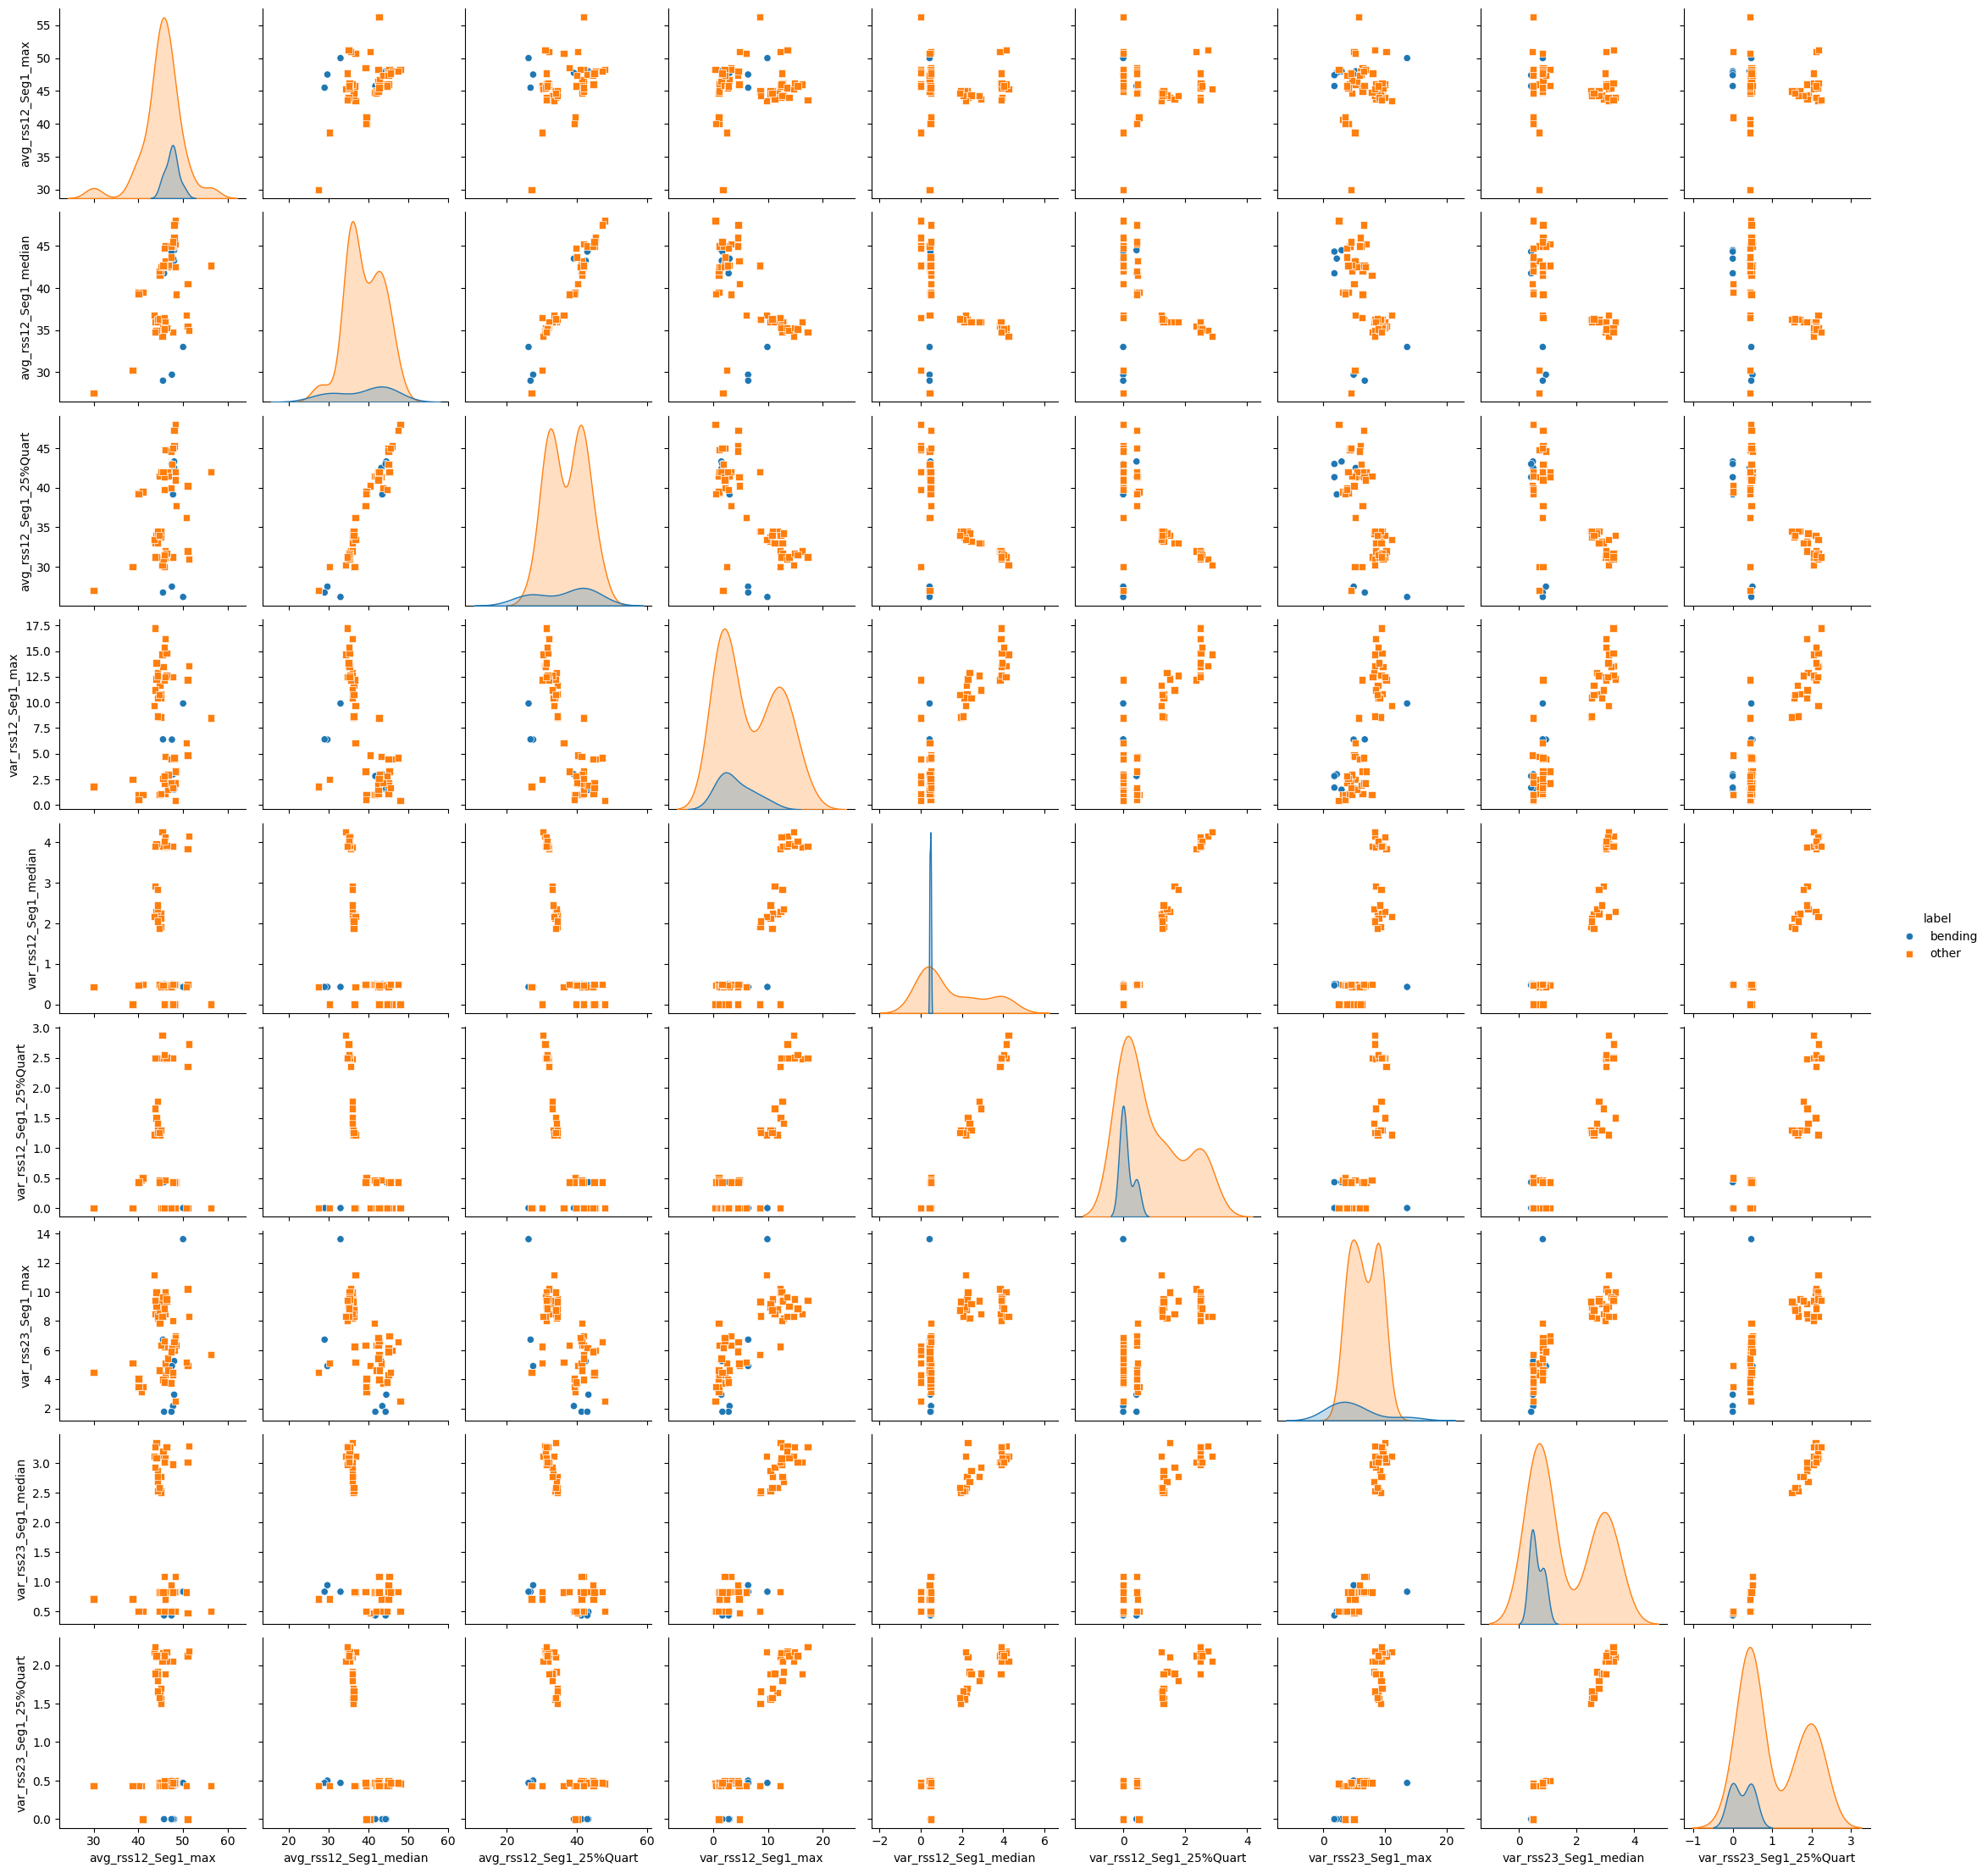

In [5]:
base_features = columnNames[1:3] + columnNames[6:] # avg_rss12, var_rss12, var_rss23
def split_series(series, n_segments):
    segment_size = len(series) // n_segments  # Base segment size
    segments = [series.iloc[i * segment_size : (i + 1) * segment_size] for i in range(n_segments - 1)]
    segments.append(series.iloc[(n_segments - 1) * segment_size:])  # Add the remainder in the last segment
    return segments
def extractFeaturesAfterSubsampling(segmentsCnt):
    featureList = []
    for activity in activities:
        for file in os.listdir(rawDataPath / activity):
            # only process the training data 
            if (file not in ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']) or (file == 'dataset3.csv' and activity in ['bending1', 'bending2']):
                data = pd.read_csv(rawDataPath / activity / file, comment='#', header=None, names=columnNames)
                features = {}
                for col in base_features:
                    segments = split_series(data[col], segmentsCnt) # np.array_split(data[col], segmentsCnt) would cause warning 
                    for i, segment in enumerate(segments):
                        features.update({
                            f"{col}_Seg{i+1}_max": np.max(segment),
                            f"{col}_Seg{i+1}_median": np.median(segment),
                            f"{col}_Seg{i+1}_25%Quart": np.percentile(segment, 25)
                        }) 
                features['activity'] = activity
                featureList.append(features)
    plot_data = pd.DataFrame(featureList)
    plot_data['label'] = plot_data['activity'].apply(lambda x: 'bending' if x in ['bending1', 'bending2'] else 'other')
    return plot_data
sns.pairplot(extractFeaturesAfterSubsampling(1), hue='label', markers=['o', 's'], diag_kind='kde')
plt.show()

ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 4(a)i?

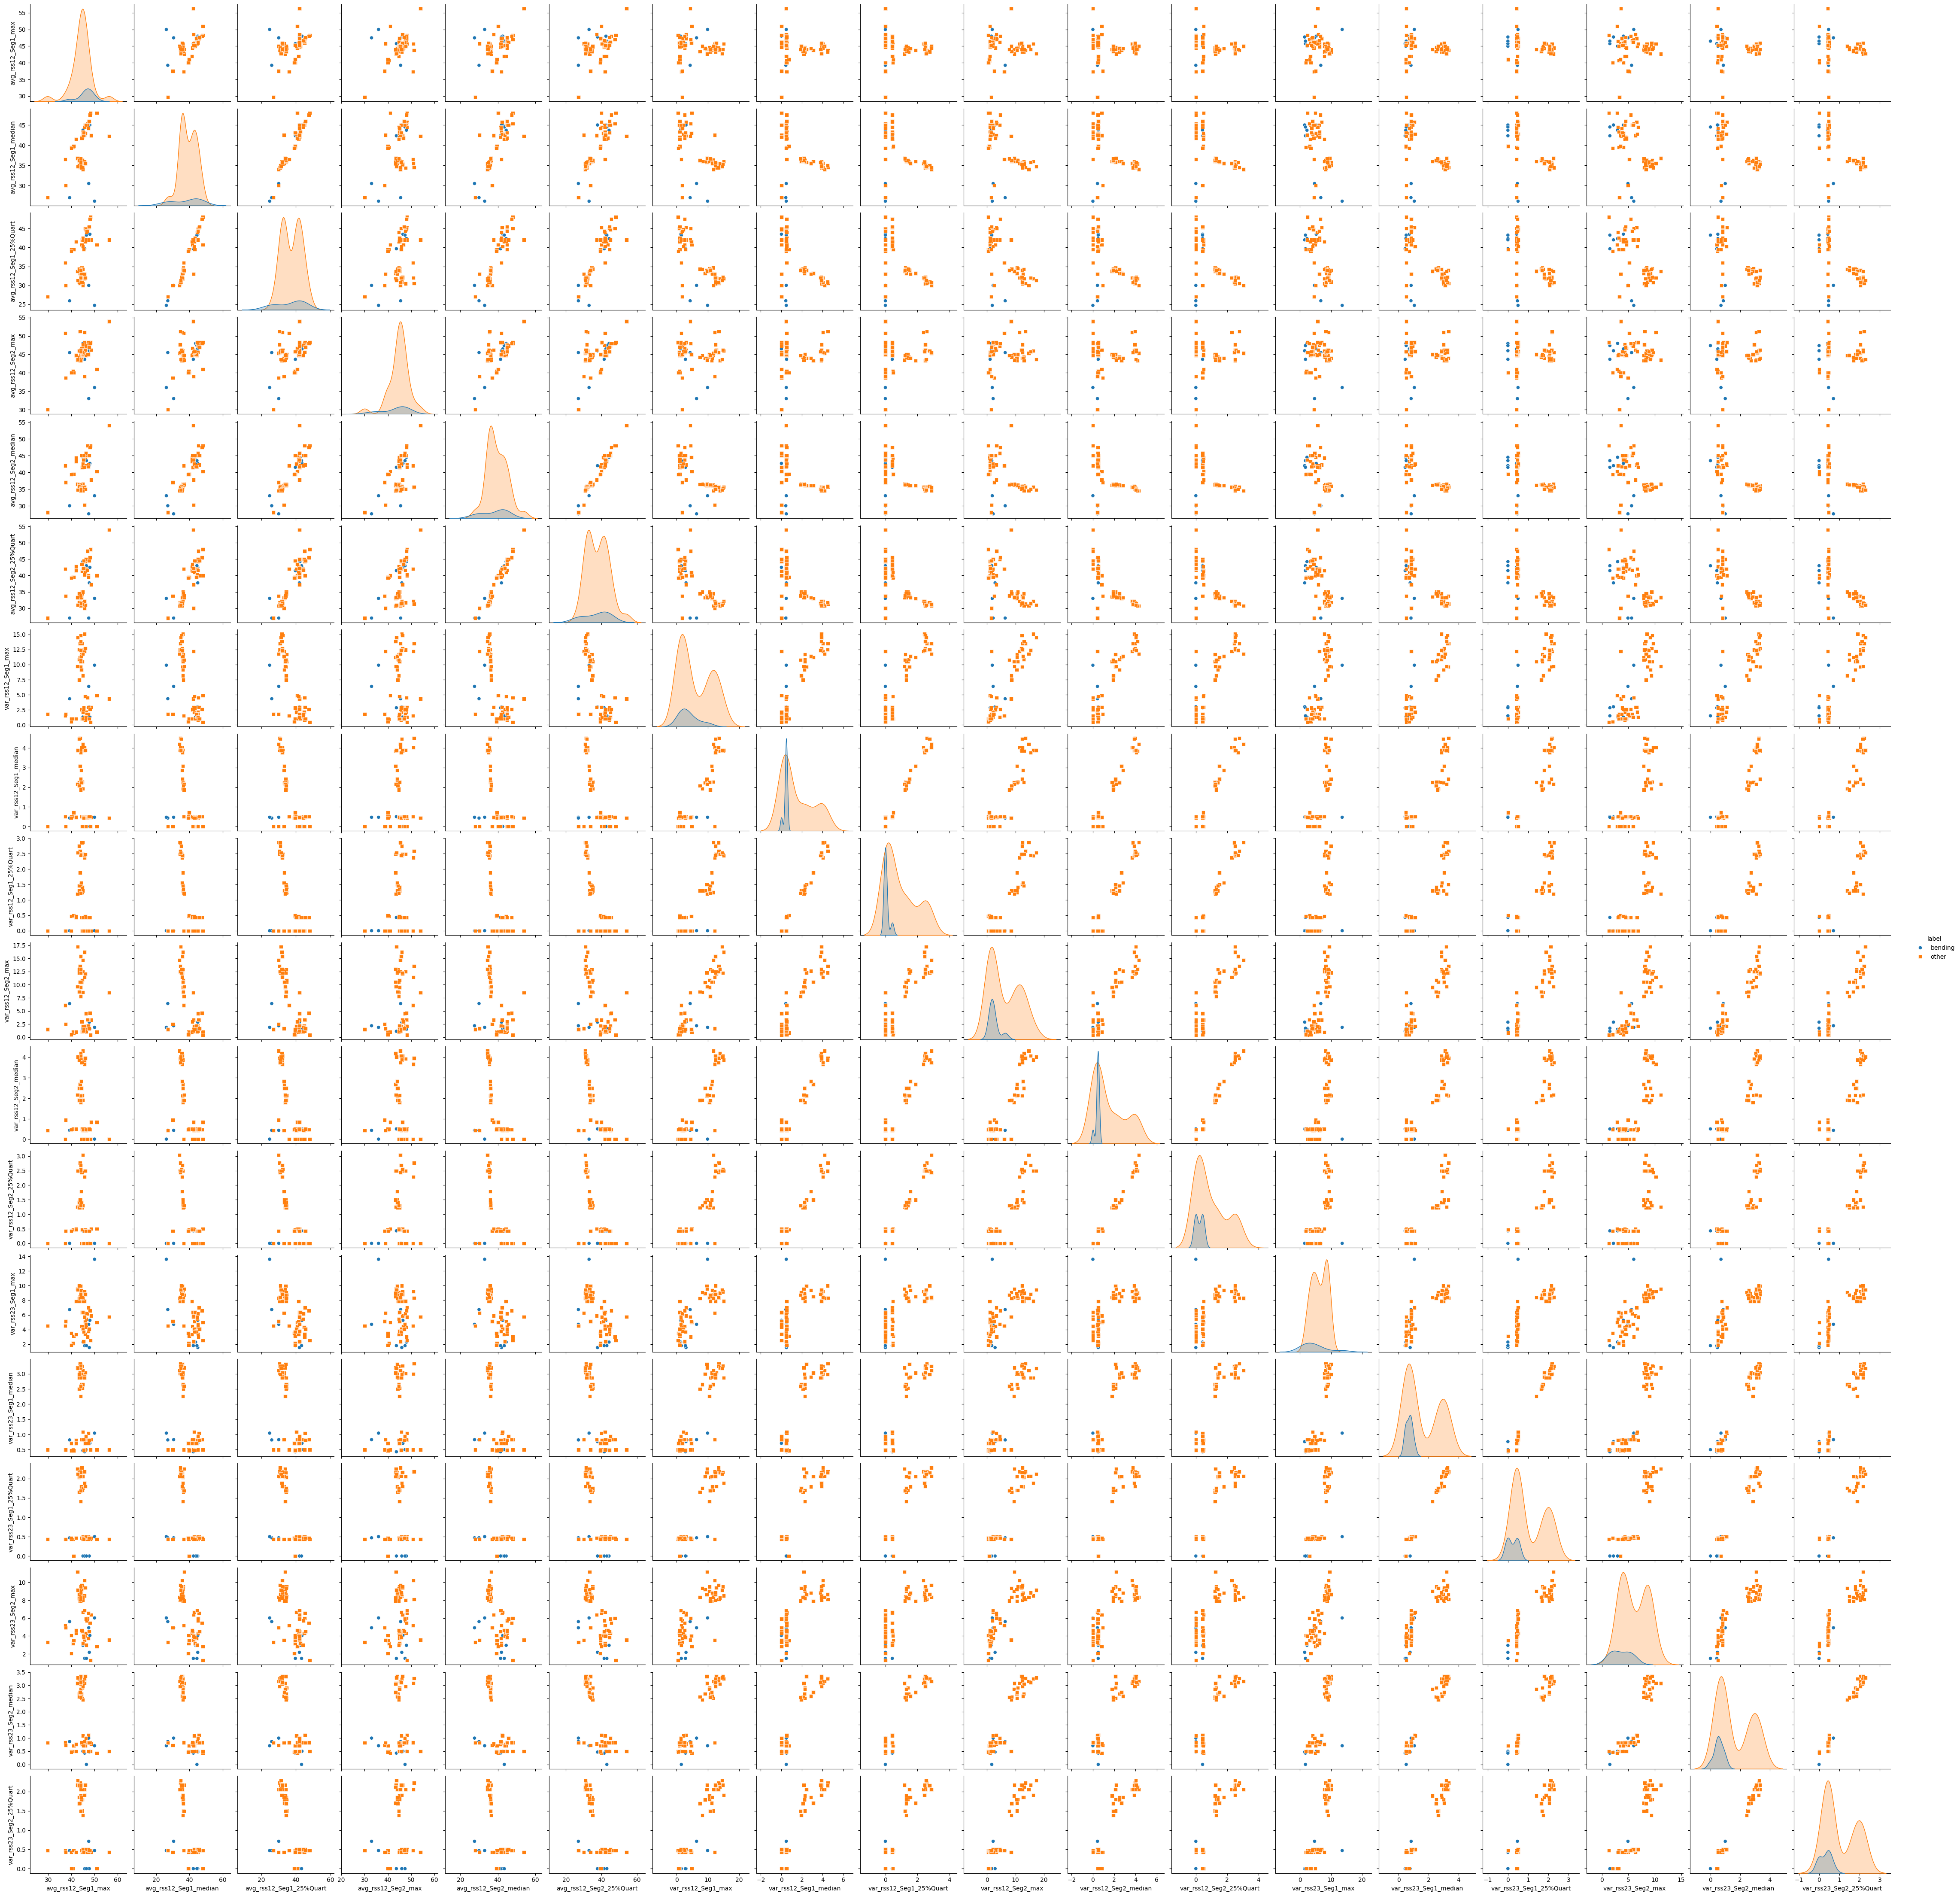

In [6]:
sns.pairplot(extractFeaturesAfterSubsampling(2), hue='label', markers=['o', 's'], diag_kind='kde')
plt.show()

Only base on the scatted plot of 4(a)i and 4(a)ii, I can NOT see any considerable difference after spliting the time series.

iii. Break each time series in your training set into $l\in {1, 2, \cdots, 20}$ time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. 

(If encountered instability of the logistic regression problem because of linearly separable classes, modify the Max-Iter parameter in logistic regression to stop the algorithm immaturely and prevent from its instability.)

(Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of $l$ and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature_selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair $(l, p)$, where $p$ is the number of features used in recursive feature elimination.)

(Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! This is an interesting problem in which the number of features changes depending on the value of the parameter $l$ that is selected via cross validation. Another example of such a problem is Principal Component Regression, where the number of principal components is selected via cross validation.)

**Right Way**: Cross Validation is only for model accessment. Apply cross-validation on the entire process — feature extraction, logistic classification model training, and feature selection. 

First, divide the original training set into 5 subsets with equal size, each turn choose 1 as validation set and the other 4 as training set. Do the same feature extration based on l value for training and validation set, then train LR model on training set, trancate features base on p value, refit models with trancated features on training set and test on validation set. We should average the 5 different validation error for each l and corresponding best p, then choose the best (l, p) pair base on the minimum average validation error. Finally, we get the best (l, p) hyperparameter choice and we need to refit this model on the entire original training set, where there might be a slightly higher traning error.

I will use the scikit-learn's *Pipeline* and *GridSearchCV* to integrate the whole process into cross-validation.

- Feature Extraction: use cunstom transformer with parameter l, nubmer of segments, for training fold and validation fold.
- Feature Extraction: use Recursive Feature Elimination with logistic regression to select p features, and the selection is based only on training fold, then applied to validation fold.
- Classification: use logistic regression with liblinear for binary classification.

**Wrong Way**: Performing feature selection (e.g., recursive feature elimination) on the entire training set before splitting it into 5 cross-validation folds, and then use cross-validation only for the final model training. Information from the validation folds leaks into the feature selction process, making Accuracy, Precision, Recall, or other metrics appear better than they truly are.


In [7]:
all_raw_features = columnNames[1:] # use all features
def split_series(series, n_segments):
        n = len(series)
        if n_segments > n:
            n_segments = n if n > 0 else 1 # Handle the case where n is 0
        segment_size = len(series) // n_segments  # Base segment size
        segments = [series.iloc[i * segment_size : (i + 1) * segment_size] for i in range(n_segments - 1)]
        segments.append(series.iloc[(n_segments - 1) * segment_size:])  # Add the remainder in the last segment
        return segments
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, segmentsCnt=1):
        self.segmentsCnt = segmentsCnt
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None): # only return the feature matrix X_transformed
        featureList = []
        for _, row in X.iterrows():
            activity = row['activity']
            file = row['file']
            data = pd.read_csv(rawDataPath / activity / file, comment='#', header=None, names=columnNames)
            features = {}
            for col in all_raw_features: 
                segments = split_series(data[col], self.segmentsCnt) # np.array_split(data[col], segmentsCnt) would cause warning 
                for i, segment in enumerate(segments):
                    segment = np.array(segment)
                    if np.isnan(segment).all(): # Handle segments with all NaNs
                        # Decide on default values for the features
                        max_value = 0
                        median_value = 0
                        quartile_25 = 0
                    else: # Compute statistics ignoring NaNs
                        max_value = np.nanmax(segment)
                        median_value = np.nanmedian(segment)
                        quartile_25 = np.nanpercentile(segment, 25)
                    features.update({
                        f"{col}_Seg{i+1}_max": max_value,
                        f"{col}_Seg{i+1}_median": median_value,
                        f"{col}_Seg{i+1}_25%Quart": quartile_25
                    }) 
            featureList.append(features)
        transformedFeatures = pd.DataFrame(featureList)
        return transformedFeatures

In [8]:

# Define the Pipeline steps
pipeline = Pipeline([
    ('featureExtractor', FeatureExtractor()), # with hyperparameter segmentsCnt
    # RFE is Recursive Feature Elimination use backward selection, with hyperparameter n_features_to_select
    ('featureSelector', RFE(estimator=LogisticRegression(solver='liblinear',  max_iter=100, penalty='l2', random_state=42))), 
    ('classifier', LogisticRegression(solver='liblinear', max_iter=100, penalty='l2', random_state=42)) # add max_iter to avoid instability due to well separated classes
])

# Dynamic parameter grid creation (adjusted for segment-dependent feature counts)
number_of_base_features = len(all_raw_features)
number_of_features_per_segment = 3  # max, median, 25%Quart

# Access Parametsers by using step name followed by a double underscore (__) and then the parameter name.
param_grid = [] 
for segmentsCnt in range(1, 21):  # l in {1, 2, ..., 20}
    total_features = number_of_base_features * segmentsCnt * number_of_features_per_segment
    # feature_range = list(range(1, total_features + 1))  # Or reduce this range for faster evaluation
    feature_range = list(range(1, min(total_features, 100) + 1))  # limit the number of features to 50
    param_grid.append({
        'featureExtractor__segmentsCnt': [segmentsCnt],  # Refers to the segmentsCnt parameter of FeatureExtractor
        'featureSelector__n_features_to_select': feature_range  # Refers to featureSselected of RFE
    })

# 5-Fold Cross-validation with stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the GridSearchCV
L2_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid, 
    cv=cv,
    scoring='accuracy',  # Can also use F1, F\beta, roc_auc, etc.
    n_jobs=-1,  # Parallel processing
    verbose=1 # only summary of overall progress
)
L2_grid_search.fit(trainDataset[['activity', 'file']], trainDataset['label']) 

Fitting 5 folds for each of 1770 candidates, totalling 8850 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('featureExtractor', FeatureExtractor()),
                                       ('featureSelector',
                                        RFE(estimator=LogisticRegression(random_state=42,
                                                                         solver='liblinear'))),
                                       ('classifier',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'featureExtractor__segment...
                         {'featureExtractor__segmentsCnt': [19],
                          'featureSelector__n_features_to_select': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10, 11,
                                                                    12, 13, 14,
                                                                    15, 16, 17,
                                                                    18, 19, 20,
                                                                    21, 22, 23,
                                                                    24, 25, 26,
                                                                    27, 28, 29,
                                                                    30, ...]},
                         {'featureExtractor__segmentsCnt': [20],
                          'featureSelector__n_features_to_select': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10, 11,
                                                                    12, 13, 14,
                                                                    15, 16, 17,
                                                                    18, 19, 20,
                                                                    21, 22, 23,
                                                                    24, 25, 26,
                                                                    27, 28, 29,
                                                                    30, ...]}],
             scoring='accuracy', verbose=1)

In [10]:
# Access the best parameters
best_params = L2_grid_search.best_params_

# Extract the best values of l and p
best_l = best_params['featureExtractor__segmentsCnt']
best_p = best_params['featureSelector__n_features_to_select']
print(f"Best l (segmentsCnt): {best_l}")
print(f"Best p (n_features_to_select): {best_p}")

# Retrieve the best estimator (pipeline)
best_pipeline = L2_grid_search.best_estimator_
# Access the feature extractor, feature selector, and classifier
best_feature_extractor = best_pipeline.named_steps['featureExtractor']
best_feature_selector = best_pipeline.named_steps['featureSelector']
best_classifier = best_pipeline.named_steps['classifier']


Best l (segmentsCnt): 8
Best p (n_features_to_select): 24


In [11]:
# Get the mask of selected features
selected_features_mask = best_feature_selector.get_support()

# After feature extraction, get the feature names
# First, we need to transform the data using the best feature extractor
X_transformed = best_feature_extractor.transform(trainDataset[['activity', 'file']])

# Get the feature names from the transformed data
feature_names = X_transformed.columns

# Get the selected feature names
selected_feature_names = feature_names[selected_features_mask]

print("Selected Features:")
print(selected_feature_names)

Selected Features:
Index(['avg_rss12_Seg5_max', 'avg_rss12_Seg5_median', 'avg_rss12_Seg6_max',
       'avg_rss12_Seg6_median', 'avg_rss12_Seg6_25%Quart',
       'var_rss12_Seg2_max', 'var_rss12_Seg3_max', 'avg_rss13_Seg2_25%Quart',
       'avg_rss13_Seg6_25%Quart', 'avg_rss13_Seg7_median',
       'var_rss13_Seg3_max', 'var_rss13_Seg6_max', 'avg_rss23_Seg1_max',
       'avg_rss23_Seg1_25%Quart', 'avg_rss23_Seg2_max',
       'avg_rss23_Seg2_median', 'avg_rss23_Seg2_25%Quart',
       'avg_rss23_Seg3_25%Quart', 'avg_rss23_Seg5_25%Quart',
       'avg_rss23_Seg8_median', 'avg_rss23_Seg8_25%Quart',
       'var_rss23_Seg3_max', 'var_rss23_Seg6_max', 'var_rss23_Seg8_max'],
      dtype='object')


iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression $\beta_i$ as well as the p-values associated with them.

In [12]:
# use the selected features to fit the logistic regression model on the entire trainSet 
X_selected = X_transformed[selected_feature_names]
y = trainDataset['label'].values

# Add a constant term for the intercept
X_selected_with_const = sm.add_constant(X_selected)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, X_selected_with_const)
result = logit_model.fit()

# Print the summary which includes coefficients and p-values
print(result.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                           24
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        11:05:36   Log-Likelihood:            -4.5165e-06
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 0.0005067
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      12.3081    470.622      0.026      0.979    -910.095     934.711
avg_rss12_Seg5_max        

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

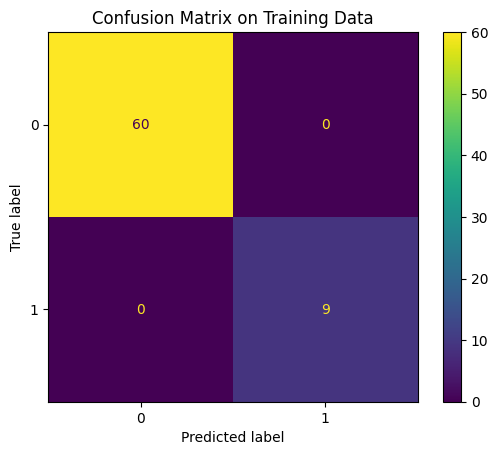

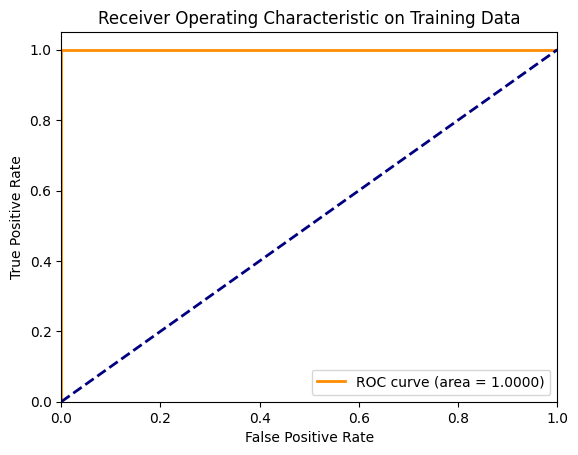

The AUC score on the training data is: 1.0000


In [13]:
# Make predictions using the best pipeline
y_pred = best_pipeline.predict(trainDataset[['activity', 'file']])
y_pred_proba = best_pipeline.predict_proba(trainDataset[['activity', 'file']])[:, 1]  # Probability estimates for the positive class
# The true labels
y_true = trainDataset['label']

def plot_ConfusionMatrix_ROC_AOC(y_pred, y_true, y_pred_proba):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.named_steps['classifier'].classes_)
    disp.plot()
    plt.title('Confusion Matrix on Training Data')
    plt.show()
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic on Training Data')
    plt.legend(loc='lower right')
    plt.show()
    print(f'The AUC score on the training data is: {roc_auc:.4f}')

plot_ConfusionMatrix_ROC_AOC(y_pred, y_true, y_pred_proba)

Since we're evaluating on the *training data*, we can see confusion matrix, ROC and AUC is optimistic because of overfitting!

v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [14]:
# Make predictions on the test set
y_test_pred = best_pipeline.predict(testDataset[['activity', 'file']])
y_test_pred_proba = best_pipeline.predict_proba(testDataset[['activity', 'file']])[:, 1]  # Probability estimates for the positive class

# True labels
y_test_true = testDataset['label'].values

# Compute Accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 1.0000


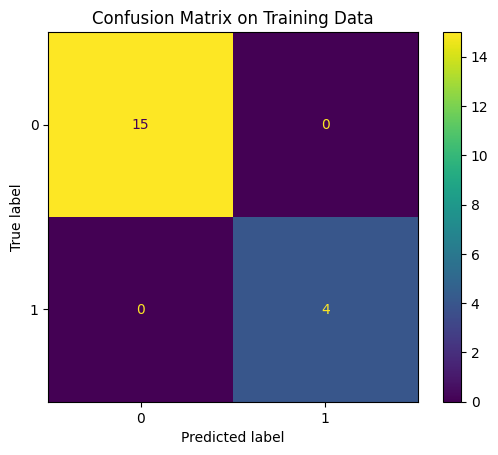

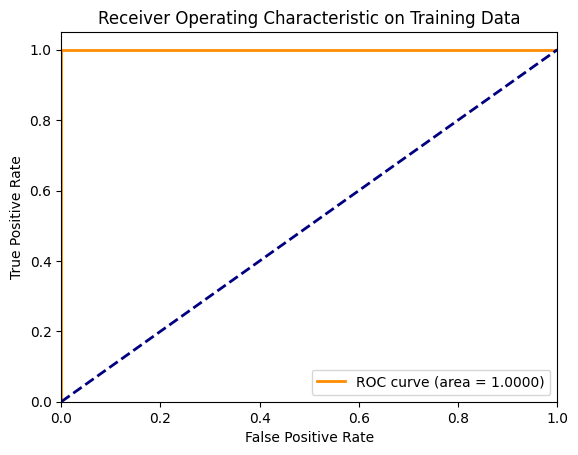

The AUC score on the training data is: 1.0000


In [20]:
plot_ConfusionMatrix_ROC_AOC(y_test_pred, y_test_true, y_test_pred_proba)

In [15]:
# Cross-validation accuracy from training
cross_val_accuracy = L2_grid_search.best_score_
print(f"Cross-validation accuracy: {cross_val_accuracy:.4f}")
print(f"Test set accuracy: {test_accuracy:.4f}")

Cross-validation accuracy: 0.9714
Test set accuracy: 1.0000


vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, we can see from the warning output of the logistic regression that *PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified*.
```python
logit_model = sm.Logit(y, X_selected_with_const)
result = logit_model.fit()
```

vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

We can see from the confusion matrices of train set that the TP is 9 while the TN is 60, obviously it's imbalanced.

In [16]:
feature_extractor = FeatureExtractor(segmentsCnt=1)

# Transform the training data to get the feature matrix
X_transformed = feature_extractor.transform(trainDataset[['activity', 'file']])
trainFeatureData = pd.concat([X_transformed, trainDataset['label']], axis=1)

# Split the original training set into positive and negative classes
train_positive = trainFeatureData[trainFeatureData['label'] == 1]
train_negative = trainFeatureData[trainFeatureData['label'] == 0]

# Upsample the positive class to match the number of negative samples
positive_class_upsampled = resample(train_positive,
                                    replace=True,  # Sample with replacement
                                    n_samples=len(train_negative),  # Match the number of negative samples
                                    random_state=42)  # For reproducibility

# Combine the upsampled positive class with the original negative class
train_balanced = pd.concat([train_negative, positive_class_upsampled])
X_train_balanced  = train_balanced.drop('label', axis=1)
y_train_balanced = train_balanced['label']

# Instantiate and fit the logistic regression model on the balanced data
logistic_reg_balanced = LogisticRegression(solver='liblinear', random_state=42)
logistic_reg_balanced.fit(X_train_balanced, y_train_balanced)

# Get the p-values of the coefficients and select the significant features
p_values = logistic_reg_balanced.coef_[0]
alpha = 0.05
significant_features = X_train_balanced.columns[p_values < alpha]
if 'const' in significant_features:
    significant_features = significant_features.drop('const')
print("Significant Features:\n", significant_features)

# Select only the significant features from the original feature matrix
X_train_balanced_significant = X_train_balanced[significant_features]
# Refit the logistic regression model using only the significant features
logistic_reg_balanced_significant = LogisticRegression(solver='liblinear', random_state=42)
logistic_reg_balanced_significant.fit(X_train_balanced_significant, y_train_balanced)


Significant Features:
 Index(['avg_rss12_Seg1_max', 'avg_rss12_Seg1_median',
       'avg_rss12_Seg1_25%Quart', 'var_rss12_Seg1_max',
       'avg_rss13_Seg1_median', 'var_rss13_Seg1_max', 'var_rss13_Seg1_median',
       'var_rss13_Seg1_25%Quart', 'var_rss23_Seg1_max',
       'var_rss23_Seg1_median', 'var_rss23_Seg1_25%Quart'],
      dtype='object')


LogisticRegression(random_state=42, solver='liblinear')

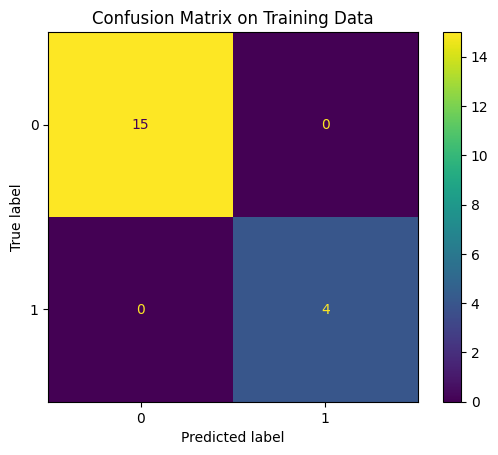

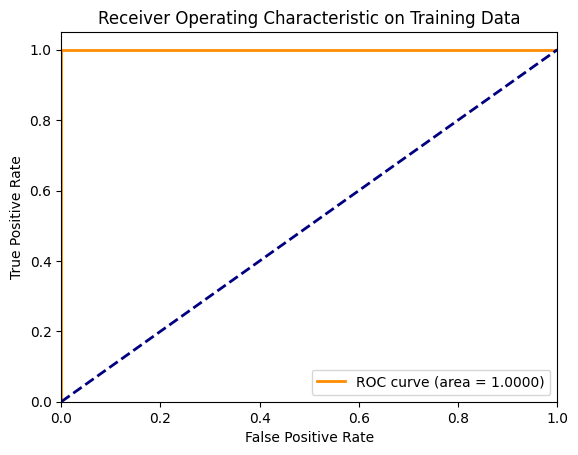

The AUC score on the training data is: 1.0000


In [17]:
# Transform the test set
X_test_transformed = feature_extractor.transform(testDataset[['activity', 'file']])
X_test_significant = X_test_transformed[significant_features]
y_test = testDataset['label']

# Make predictions
y_test_pred = logistic_reg_balanced_significant.predict(X_test_significant)
y_test_pred_proba = logistic_reg_balanced_significant.predict_proba(X_test_significant)[:, 1]

plot_ConfusionMatrix_ROC_AOC(y_test_pred, y_test, y_test_pred_proba)

We can see after upsampling the TP cases of training set, a simple logistic regression model with *liblinear* solver and the original 6*3 features can also get a high accuracy on test set.

#### 4(b) Binary Classification Using $\mathcal{L}_1-penalized$ Logistic Regression
i. Repeat 4(a)iii using $\mathcal{L}_1-penalized$ logistic regression, i.e. instead of using p-values for variable selection, use $\mathcal{L}_1$ regularization. Here you should use normalized/standardized features. And you have to cross-validate for both l, the number of time series into which you break each of your instances, and $\lambda$, the weight of $\mathcal{L}_1$ penalty in your logistic regression objective function (or $C$, the budget). Package *Liblinear* usually perform cross-validation for $\lambda$ automatically.

In [19]:
# Instantiate FeatureExtractor (with a placeholder parameter for GridSearchCV to optimize)
feature_extractor = FeatureExtractor()

# Create the pipeline
pipeline = Pipeline([
    ('featureExtractor', feature_extractor),  # Feature extraction step
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))  # L1-penalized logistic regression
])

# Parameter grid for GridSearchCV
param_grid = {
    'featureExtractor__segmentsCnt': list(range(1, 21)),  # l in {1, 2, ..., 20}
    'classifier__C': np.logspace(-4, 4, 10)  # C values from 1e-4 to 1e4 in log space
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
L1_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1 # only summary of overall progress
)

# Fit the GridSearchCV
L1_grid_search.fit(trainDataset[['activity', 'file']], trainDataset['label'])

# Access the best parameters
best_params = L1_grid_search.best_params_
best_l = best_params['featureExtractor__segmentsCnt']
best_C = best_params['classifier__C']

print(f"Best l (segmentsCnt): {best_l}")
print(f"Best C (regularization strength): {best_C}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best l (segmentsCnt): 17
Best C (regularization strength): 0.3593813663804626


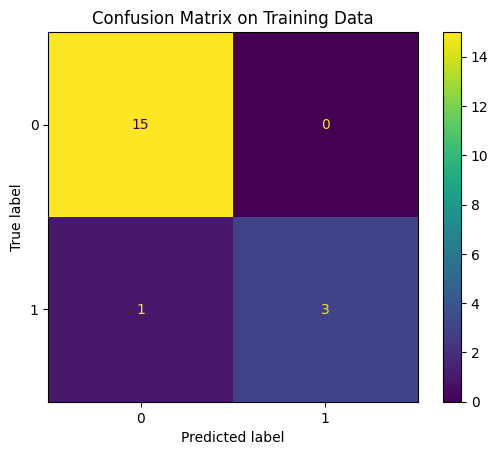

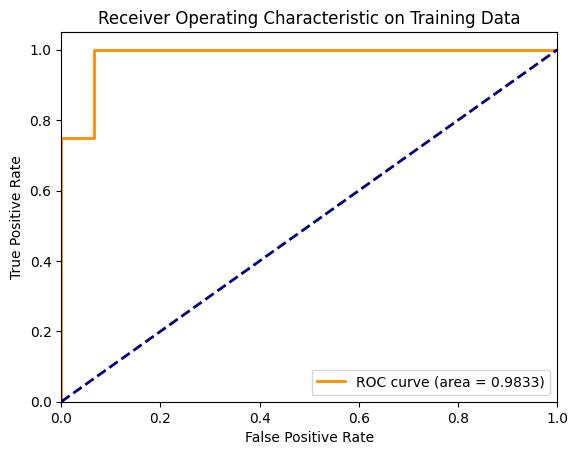

The AUC score on the training data is: 0.9833
Cross-validation accuracy: 0.9571
Test set accuracy: 1.0000


In [32]:
# Get the best estimator
# this already includes the refitted pipeline with best parameters, don't need to manually refit!
best_pipeline = L1_grid_search.best_estimator_

# Transform the test data and make predictions using the best pipeline
y_test_true = testDataset['label']
y_test_pred = best_pipeline.predict(testDataset[['activity', 'file']])
y_test_pred_proba = best_pipeline.predict_proba(testDataset[['activity', 'file']])[:, 1]
plot_ConfusionMatrix_ROC_AOC(y_test_pred, y_test_true, y_test_pred_proba)

# Cross-validation accuracy from training
cross_val_accuracy = L1_grid_search.best_score_
print(f"Cross-validation accuracy: {cross_val_accuracy:.4f}")
print(f"Test set accuracy: {test_accuracy:.4f}")

ii. Compare the $\mathcal{L}_1-penalized$ with variable selection using p-values. Which one performs better? Which one is easier to implement?

Base on the Confusion Matrix, we can see $\mathcal{L}_1-penalized$ logistical regression model has a higher *Type I Error*, besides it also has a smaller AUC value (0.9833 < 1.0000). Consequently, we can conclude $\mathcal{L}_1-penalized$ model perform worse. 

However, $\mathcal{L}_1-penalized$ logistic model is easier to implement because its hyperparameter $C$ does NOT affected by $l$, i.e. time series segments count, and we do NOT need to add Max Iteration limitation for $\mathcal{L}_1-penalized$.

#### 4(c) Multi-class Classification (The Realistic Case)
i. Find the best l in the same way as you found it in 4(b)i to build an $\mathcal{L}_1-penalized$ multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible. (For example, the pROC package in R does the job.)

In [63]:
# Create the pipeline
pipeline = Pipeline([
    ('featureExtractor', feature_extractor),  # Feature extraction step
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter=1000, tol=0.01))  # L1-penalized logistic regression
])

# Parameter grid for GridSearchCV
param_grid = {
    'featureExtractor__segmentsCnt': list(range(1, 21)),  # l in {1, 2, ..., 20}
    'classifier__C': np.logspace(-4, 2, 10)  # C values from 1e-4 to 1e4 in log space
}

# modify the cross-validation strategy because the training data for bending2 is of size 4
multi_class_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Set up GridSearchCV
multi_class_L1_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=multi_class_cv,
    scoring='f1_macro', # can also use 'f1_macro', 'f1_weighted' for multi-class or 'accuracy'.
    n_jobs=-1,  # Use all available cores
    verbose=1 # only summary of overall progress
)

# Fit the GridSearchCV
multi_class_L1_grid_search.fit(trainDataset[['activity', 'file']], trainDataset['activity'])

# Access the best parameters
multi_class_best_params = multi_class_L1_grid_search.best_params_
multi_class_best_l = multi_class_best_params['featureExtractor__segmentsCnt']
multi_class_best_C = multi_class_best_params['classifier__C']

print(f"Best l for multi-class (segmentsCnt): {multi_class_best_l}")
print(f"Best C for multi-class (regularization strength): {multi_class_best_C}")

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Best l for multi-class (segmentsCnt): 5
Best C for multi-class (regularization strength): 4.641588833612772


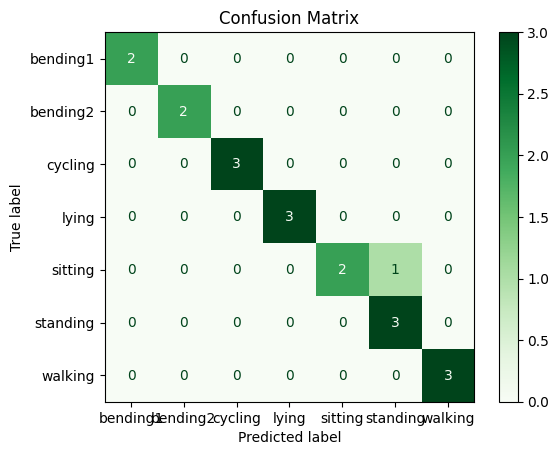

In [67]:
# Get the best estimator
best_pipeline = multi_class_L1_grid_search.best_estimator_

# Predict the labels for the test set
y_test_true = testDataset['activity']
y_test_pred = best_pipeline.predict(testDataset[['activity', 'file']])

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred, labels=multi_class_L1_grid_search.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multi_class_L1_grid_search.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

In [65]:
# Classification report to check precision, recall, f1-score
report = classification_report(y_test_true, y_test_pred) 
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    bending1       1.00      1.00      1.00         2
    bending2       1.00      1.00      1.00         2
     cycling       1.00      1.00      1.00         3
       lying       1.00      1.00      1.00         3
     sitting       1.00      0.67      0.80         3
    standing       0.75      1.00      0.86         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.95        19
   macro avg       0.96      0.95      0.95        19
weighted avg       0.96      0.95      0.95        19



For ROC curves, I first binarize the true labels using label_binarize so that each label is represented as a binary (one-vs-rest) format, then compute the false positive rate (FPR), true positive rate (TPR), and area under the curve (AUC) for each class using roc_curve and auc.

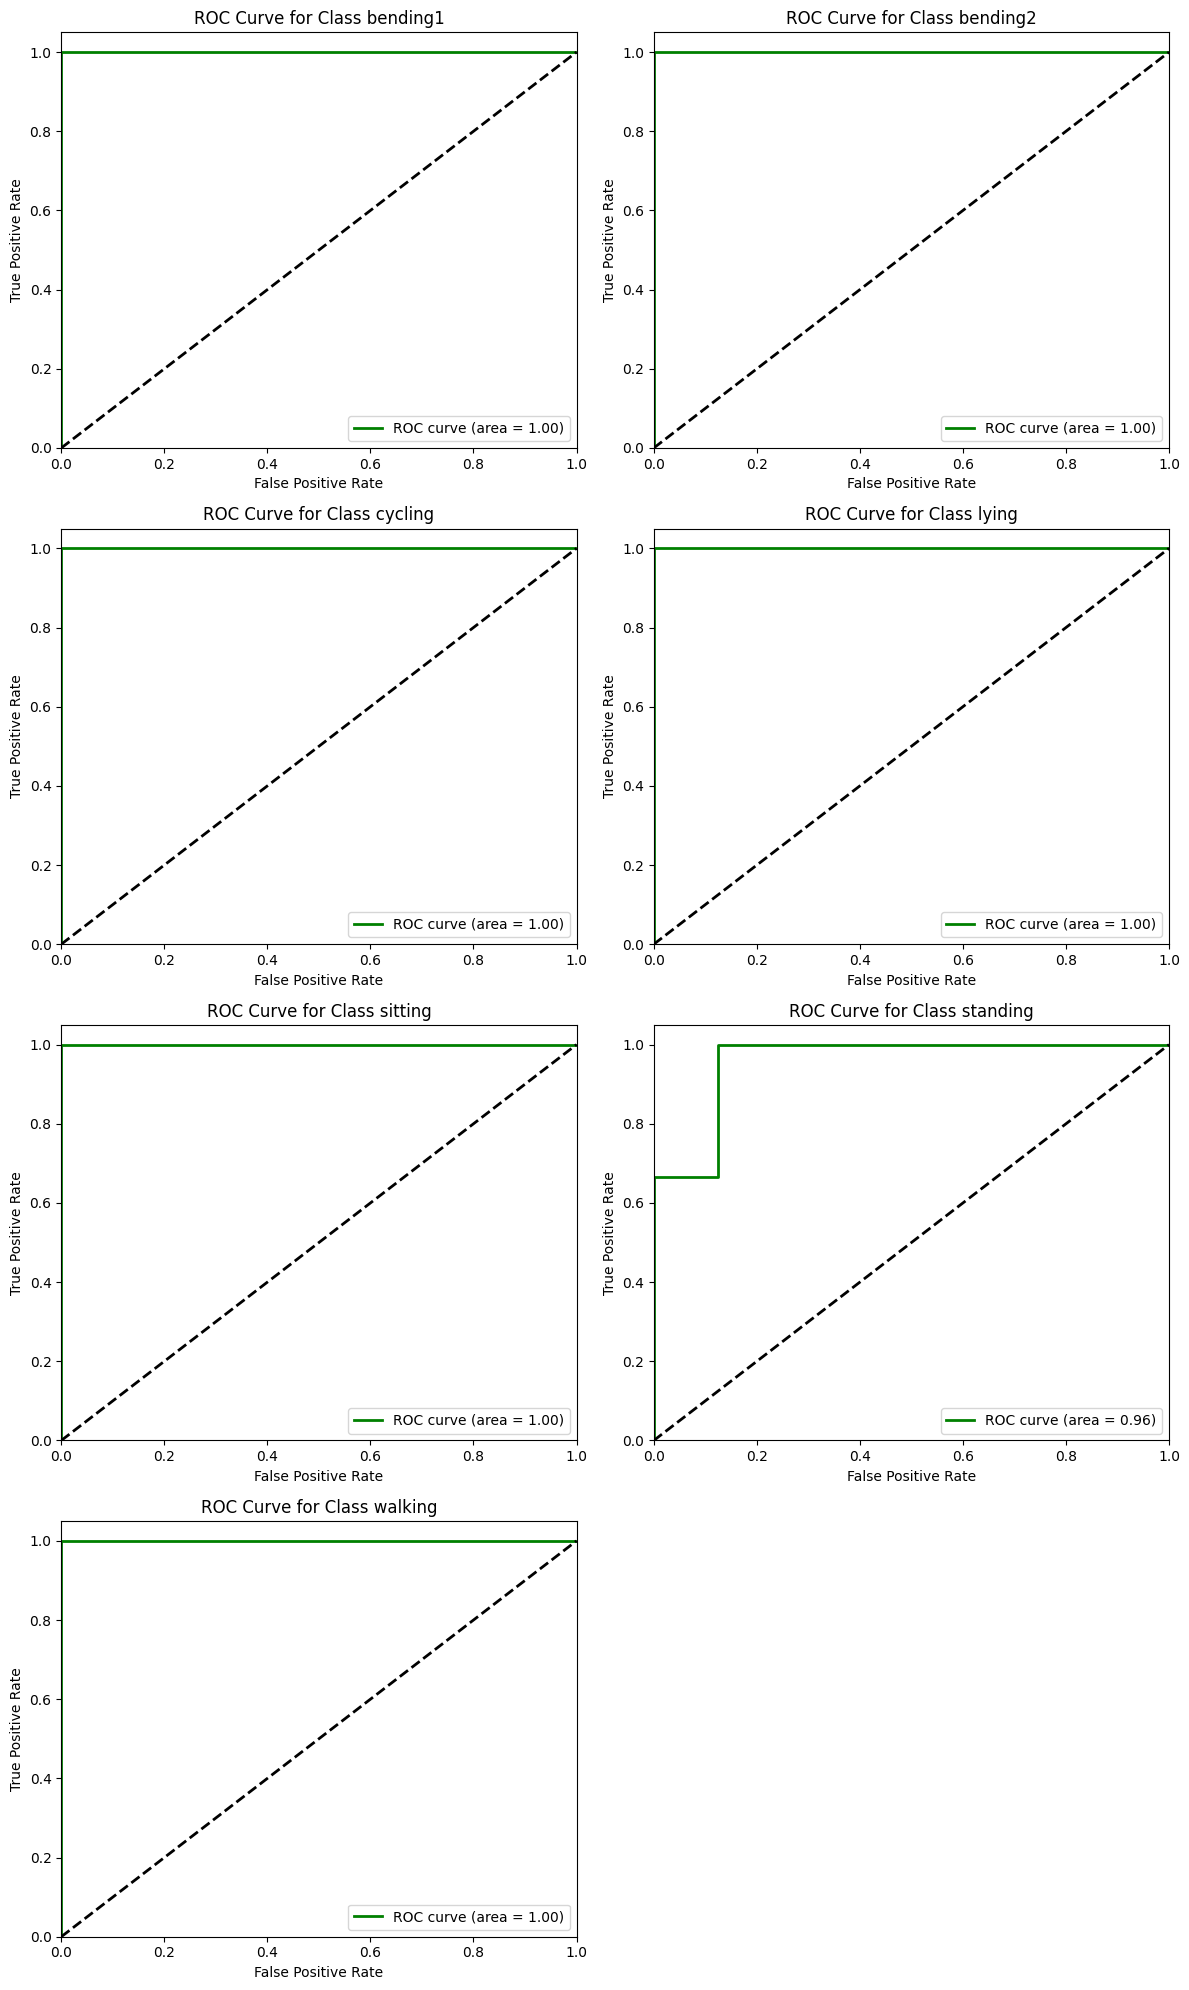

In [69]:
# Predict the probabilities for each class
y_test_pred_proba = best_pipeline.predict_proba(testDataset[['activity', 'file']])

# Binarize the true labels for ROC computation (One-vs-Rest strategy)
y_test_binarized = label_binarize(y_test_true, classes=multi_class_L1_grid_search.classes_)

n_classes = len(multi_class_L1_grid_search.classes_) # Number of classes for multi-class classification
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create subplots: Adjust rows and columns based on the number of classes
n_rows = (n_classes + 1) // 2  # Arrange in 2 columns
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 5))
axes = axes.ravel()  # Flatten to easily iterate over

# Plot ROC curve for each class in its own subplot
for i, class_label in enumerate(multi_class_L1_grid_search.classes_):
    ax = axes[i]
    ax.plot(fpr[i], tpr[i], color='g', lw=2,
            label=f'ROC curve (area = {roc_auc[i]:0.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Class {class_label}')
    ax.legend(loc="lower right")

# If there are more subplots than classes, hide the empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Delete extra axes if needed

# Adjust layout
plt.tight_layout()
plt.show()

ii. Repeat 4(c)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

- Gaussian priors

In [39]:
# Create the pipeline with Gaussian Naive Bayes
pipeline_gnb = Pipeline([
    ('featureExtractor', feature_extractor),  # Feature extraction step
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', GaussianNB())  # Gaussian Naive Bayes
])

# Example of param_grid for GridSearchCV
param_grid_gnb = {
    'featureExtractor__segmentsCnt': list(range(1, 21))  # Example: l in {1, 2, ..., 20}
}

# Set up GridSearchCV
multi_class_GaussianNB_grid_search = GridSearchCV(
    estimator=pipeline_gnb,
    param_grid=param_grid_gnb,
    cv=multi_class_cv,
    scoring='f1_macro', # can also use 'f1_macro', 'f1_weighted' for multi-class or 'accuracy'.
    n_jobs=-1,  # Use all available cores
    verbose=1 # only summary of overall progress
)

# Fit the GridSearchCV
multi_class_GaussianNB_grid_search.fit(trainDataset[['activity', 'file']], trainDataset['activity'])

Fitting 4 folds for each of 20 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('featureExtractor', FeatureExtractor()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid={'featureExtractor__segmentsCnt': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20]},
             scoring='f1_macro', verbose=1)

Best l for multi-class Gaussian Naive Bayes (segmentsCnt): 2


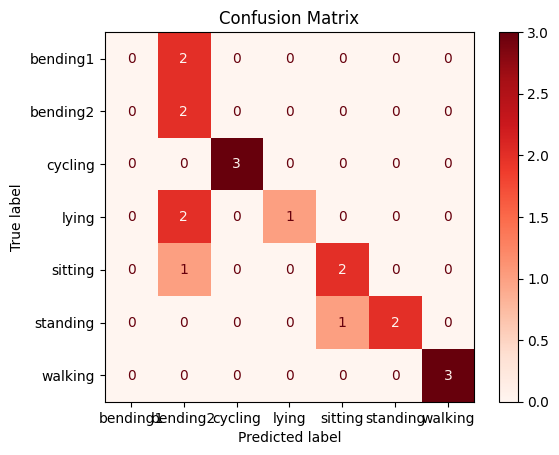

In [54]:
# Access the best parameters
multi_class_GaussianNB_best_params = multi_class_GaussianNB_grid_search.best_params_
multi_class_GaussianNB_best_l = multi_class_GaussianNB_best_params['featureExtractor__segmentsCnt']
print(f"Best l for multi-class Gaussian Naive Bayes (segmentsCnt): {multi_class_GaussianNB_best_l}")

# Get the best estimator
best_GaussianNB_pipeline = multi_class_GaussianNB_grid_search.best_estimator_

# Predict the labels for the test set
y_test_true = testDataset['activity']
y_test_pred = best_GaussianNB_pipeline.predict(testDataset[['activity', 'file']])

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred, labels=multi_class_GaussianNB_grid_search.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multi_class_GaussianNB_grid_search.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.show()

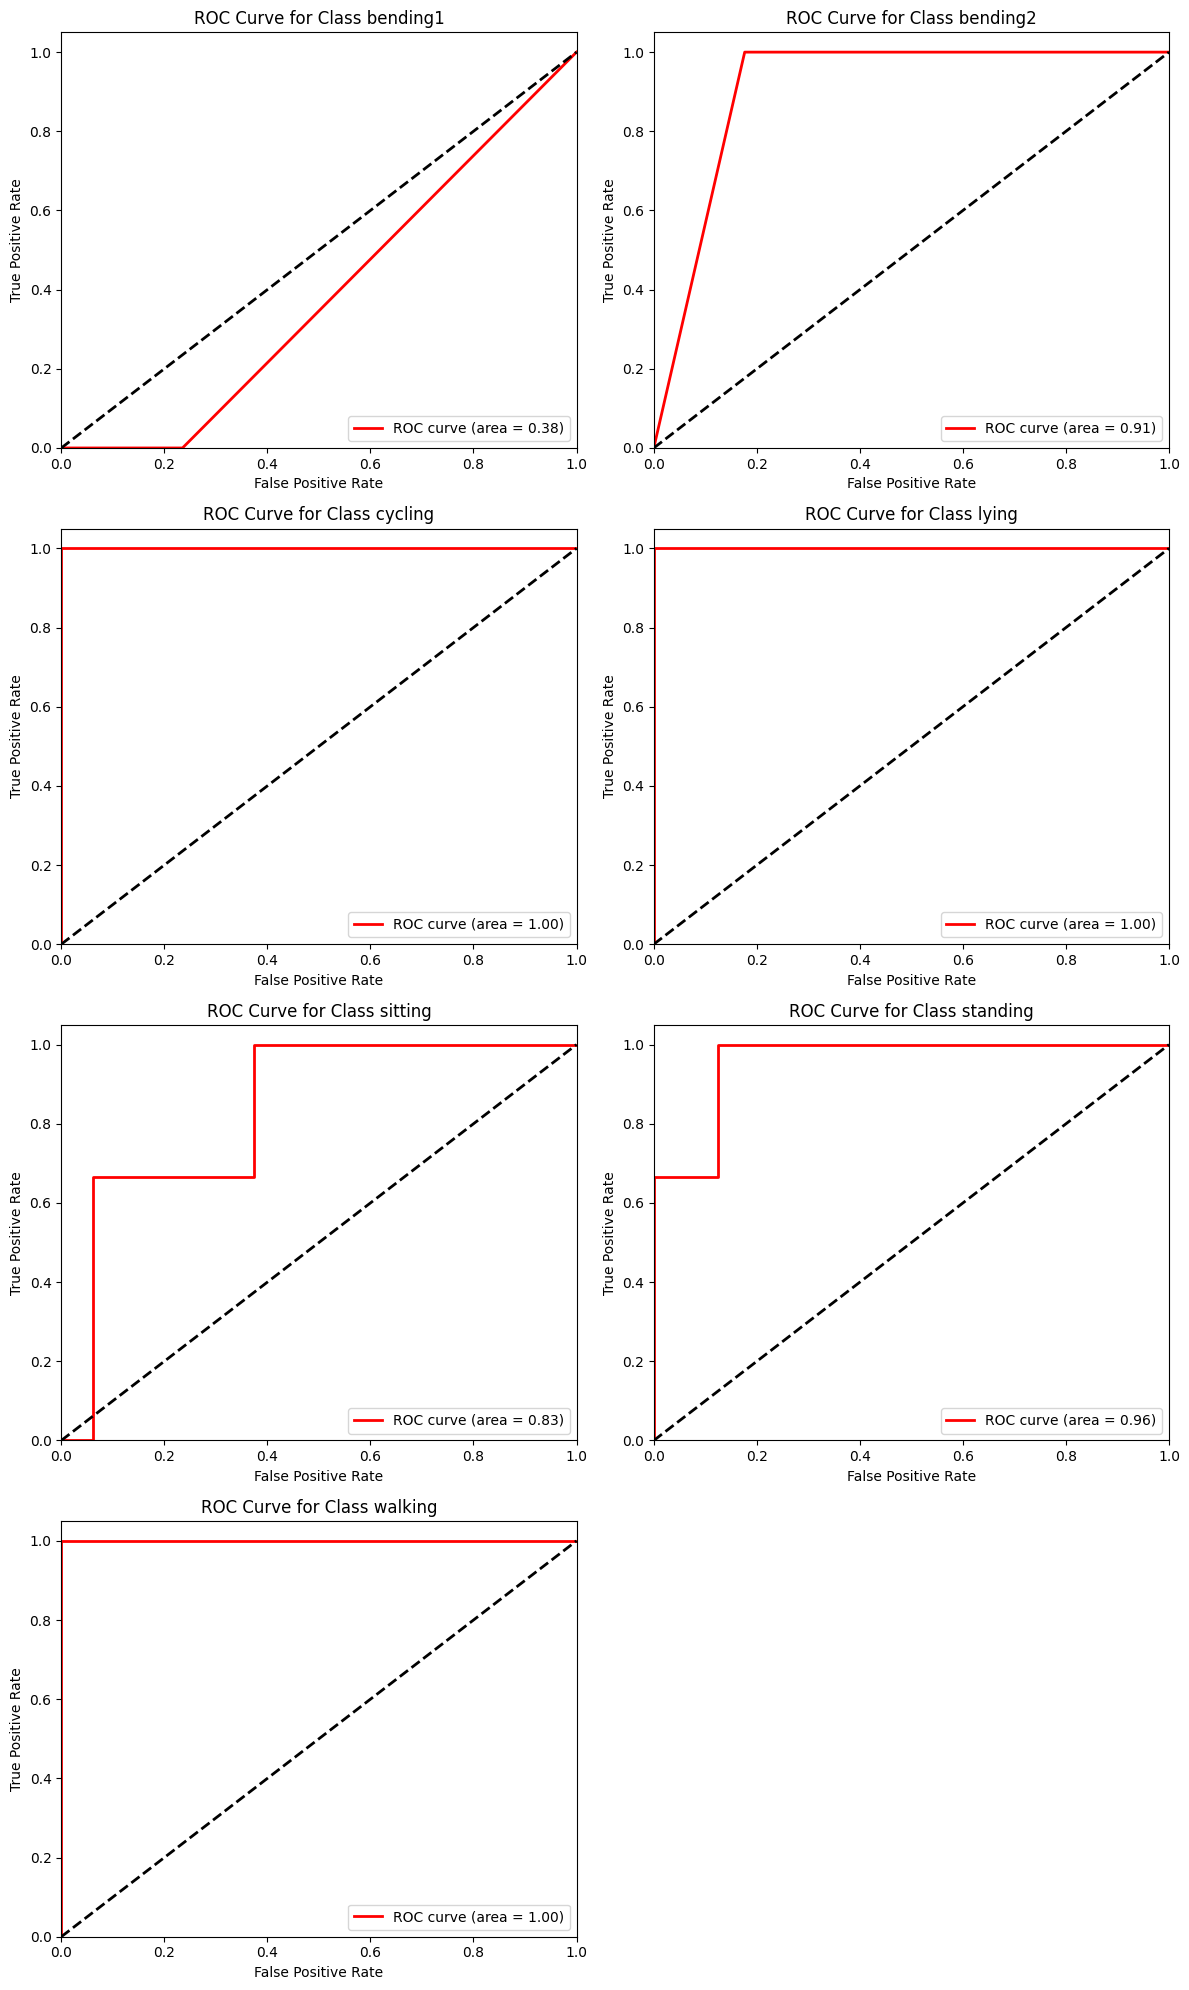

In [55]:
# Predict the probabilities for each class
y_test_pred_proba = best_GaussianNB_pipeline.predict_proba(testDataset[['activity', 'file']])

# Binarize the true labels for ROC computation (One-vs-Rest strategy)
y_test_binarized = label_binarize(y_test_true, classes=multi_class_GaussianNB_grid_search.classes_)

n_classes = len(multi_class_GaussianNB_grid_search.classes_) # Number of classes for multi-class classification
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create subplots: Adjust rows and columns based on the number of classes
n_rows = (n_classes + 1) // 2  # Arrange in 2 columns
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 5))
axes = axes.ravel()  # Flatten to easily iterate over

# Plot ROC curve for each class in its own subplot
for i, class_label in enumerate(multi_class_GaussianNB_grid_search.classes_):
    ax = axes[i]
    ax.plot(fpr[i], tpr[i], color='r', lw=2,
            label=f'ROC curve (area = {roc_auc[i]:0.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Class {class_label}')
    ax.legend(loc="lower right")

# If there are more subplots than classes, hide the empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Delete extra axes if needed

# Adjust layout
plt.tight_layout()
plt.show()

- Multinomial 

In [44]:
# Create the pipeline with Multinomial Naive Bayes
pipeline_mnb = Pipeline([
    ('featureExtractor', feature_extractor),  # Feature extraction step
    ('scaler', MinMaxScaler()),  # transform to non-negative values
    ('classifier', MultinomialNB())  # Multinomial Naive Bayes
])

# Example of param_grid for GridSearchCV (if you want to optimize any parameters)
param_grid_mnb = {
    'featureExtractor__segmentsCnt': list(range(1, 21)), 
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0, 5.0], 
}

# Set up GridSearchCV
multi_class_MultinomialNB_grid_search = GridSearchCV(
    estimator=pipeline_mnb,
    param_grid=param_grid_mnb,
    cv=multi_class_cv,
    scoring='f1_macro', # can also use 'f1_macro', 'f1_weighted' for multi-class or 'accuracy'.
    n_jobs=-1,  # Use all available cores
    verbose=1 # only summary of overall progress
)

# Fit the GridSearchCV
multi_class_MultinomialNB_grid_search.fit(trainDataset[['activity', 'file']], trainDataset['activity'])

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('featureExtractor', FeatureExtractor()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
                         'featureExtractor__segmentsCnt': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20]},
             scoring='f1_macro', verbose=1)

Best l for multi-class Gaussian Naive Bayes (segmentsCnt): 2


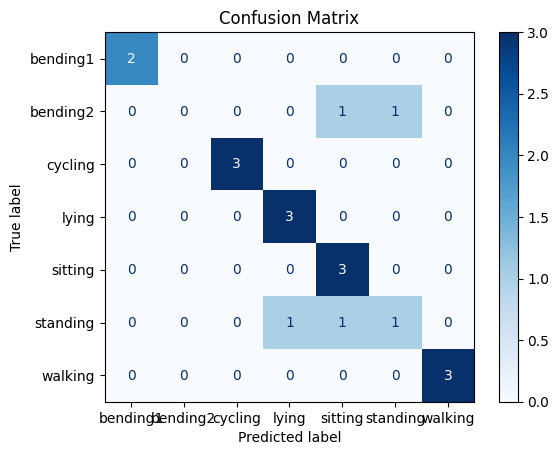

In [70]:
# Access the best parameters
multi_class_MultinomialNB_best_params = multi_class_MultinomialNB_grid_search.best_params_
multi_class_MultinomialNB_best_l = multi_class_MultinomialNB_best_params['featureExtractor__segmentsCnt']
print(f"Best l for multi-class Gaussian Naive Bayes (segmentsCnt): {multi_class_GaussianNB_best_l}")

# Get the best estimator
best_MultinomialNB_pipeline = multi_class_MultinomialNB_grid_search.best_estimator_

# Predict the labels for the test set
y_test_true = testDataset['activity']
y_test_pred = best_MultinomialNB_pipeline.predict(testDataset[['activity', 'file']])

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred, labels=multi_class_MultinomialNB_grid_search.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multi_class_MultinomialNB_grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

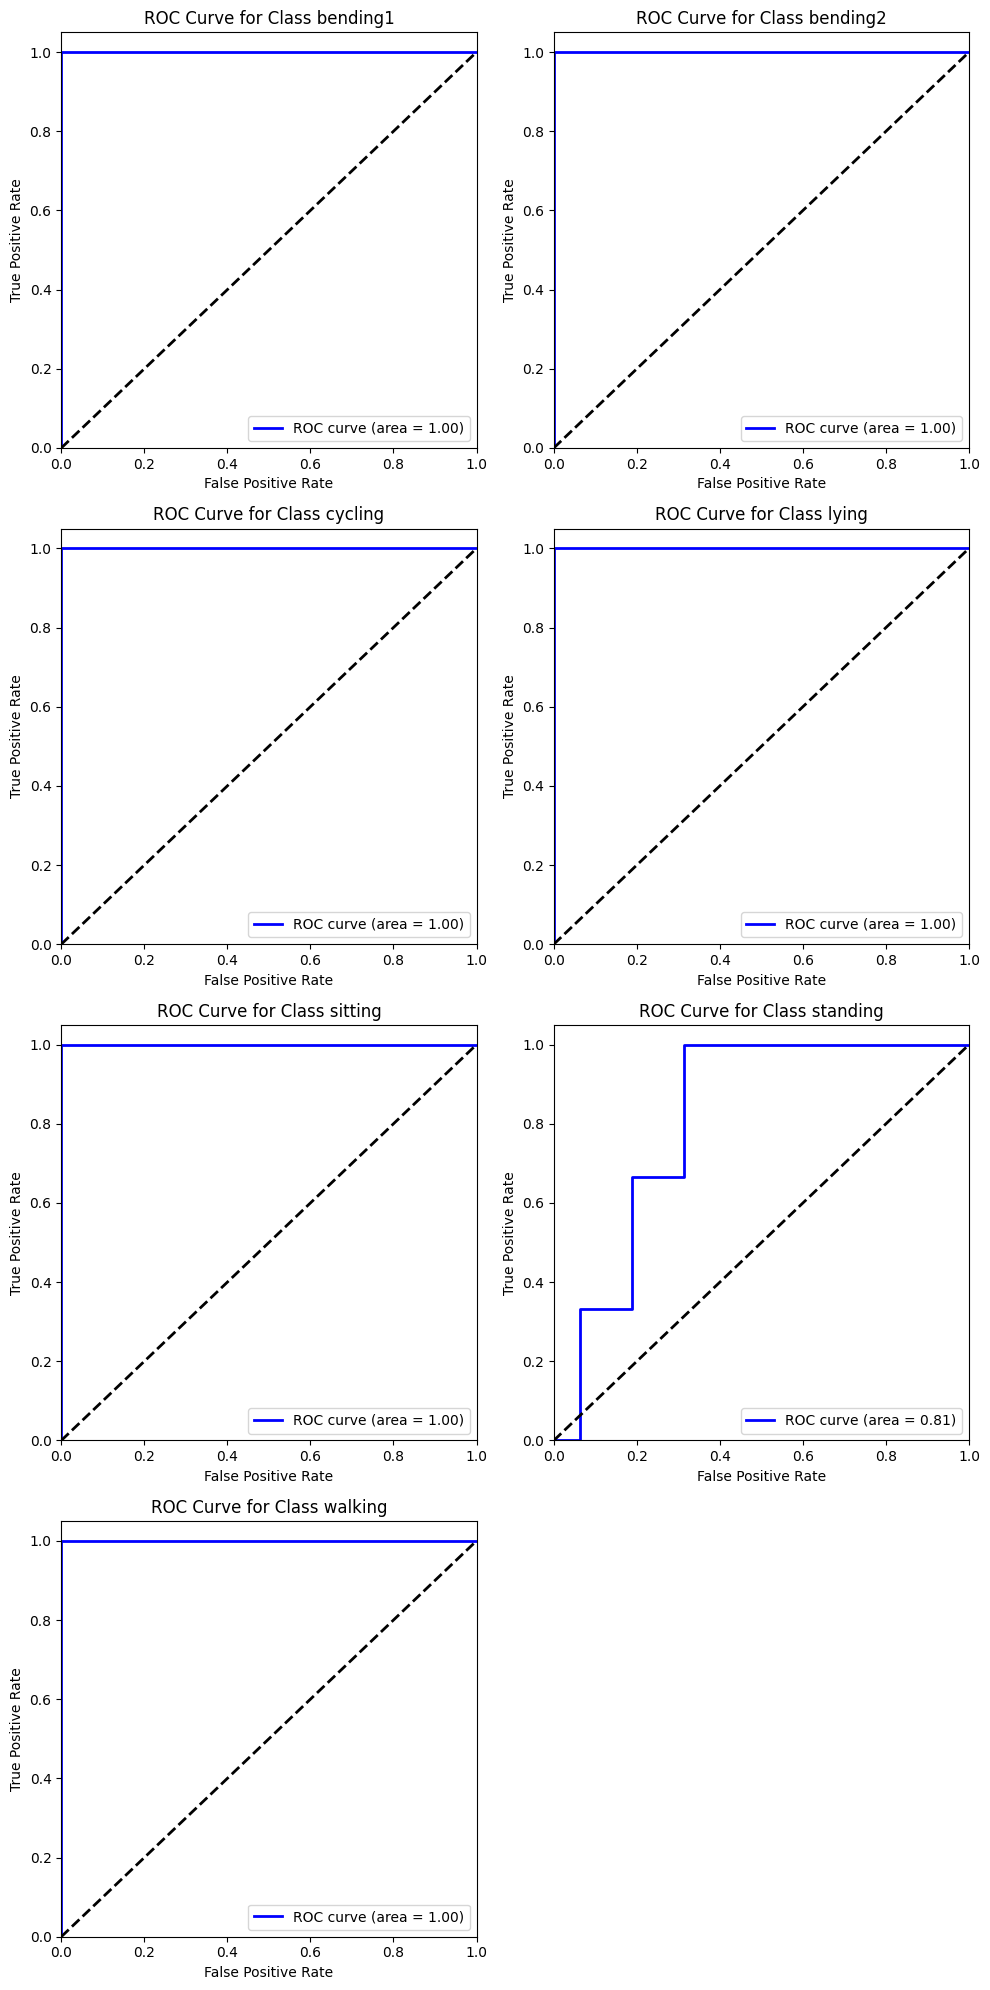

In [72]:
# Predict the probabilities for each class
y_test_pred_proba = best_MultinomialNB_pipeline.predict_proba(testDataset[['activity', 'file']])

# Binarize the true labels for ROC computation (One-vs-Rest strategy)
y_test_true = testDataset['activity']
y_test_binarized = label_binarize(y_test_true, classes=multi_class_MultinomialNB_grid_search.classes_)

n_classes = len(multi_class_MultinomialNB_grid_search.classes_) # Number of classes for multi-class classification
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create subplots: Adjust rows and columns based on the number of classes
n_rows = (n_classes + 1) // 2  # Arrange in 2 columns
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(10, n_rows * 5))
axes = axes.ravel()  # Flatten to easily iterate over

# Plot ROC curve for each class in its own subplot
for i, class_label in enumerate(multi_class_MultinomialNB_grid_search.classes_):
    ax = axes[i]
    ax.plot(fpr[i], tpr[i], color='b', lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Class {class_label}')
    ax.legend(loc="lower right")

# If there are more subplots than classes, hide the empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Delete extra axes if needed

# Adjust layout
plt.tight_layout()
plt.show()

Base on the ROC curve of the two different Naive Bayes classifier, we can see Multinomial priors works better on lying and sitting classes than Gaussian priors. While, gaussian priors works better on standing class. 

The overall accuracy of Naive Bayesian classifier with Gaussian and Multinomial has no difference.

iii. Which method is better for multi-class classification in this problem?

Base on the results of confusion matrics and ROC curves for different class, we can conclude that multinomial regression with L1 penalty works better for this multi-class classification problem.

#### 3. Quadratic Discirminant Analysis Model
This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix, without making the assumption that $\sigma_1^2 = \cdots = \sigma_K^2$. We consider the simple case where p = 1; i.e. there is only one feature.

Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, $X ∼ N(\mu_k, \sigma_k^2)$. Recall that the density function for the one-dimensional normal distribution is 
$$f_k(x) = \frac{1}{\sqrt{2\pi}\sigma_k}exp(-\frac{1}{2\sigma_k^2}(x-\mu_k)^2)$$ 
Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

**Answer:** Bayes classifier would assigns a new observation x to class k for the largest posterior probability 
$$P(Y=k|X=x) = \frac{P(X=x|Y=k)P(Y=k)}{P(X=x)}$$
which can be simplified into the following decision rule:
$$\hat{k}(x) = \arg \max_k P(X=x|Y=k)P(Y=k) = \arg \max_k log(f_k(x)) + log(P(Y=k))$$
where $f_k(x)$ is given by the normal distribution, so we can get:
$$\hat{k}(x) = \arg \max_k (log P(Y=k) - \log \sigma - \frac{(x-\mu_k)^2}{2\sigma_k^2})$$
The decision rule to classify x into class k is by maximizing the log-posterior, where the last term $-\frac{(x-\mu_k)^2}{2\sigma_k^2}$ is quadratic in x. The decision boundary between any two classes k and j should also contains quadratic terms in x.


#### 4. Calculate the posterior probability
Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was $\bar{X} = 10$, while the mean for those that didn’t was $\bar{X} = 0$. In addition, the variance of X for these two sets of companies was $\sigma^2 = 36$. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

**Answer:**
$$\begin{align}P(Dividend|X=4) &= \frac{P(X=4|Divident)P(Dividend)}{P(X=4)}\\ 
   &= \frac{P(X=4|Divident)P(Dividend)}{P(X=4|Divident)P(Dividend) + P(X=4|No Divident)P(No Dividend)}\\
   &= \frac{\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(4-10)^2}{2*36}) * 0.8}{\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(4-10)^2}{2*36})*0.8 + \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(4-0)^2}{2*36})*0.2} \\
   &= \frac{exp(-0.5)*0.8}{exp(-0.5)*0.8 + exp(-2/9)*0.2}
   \end{align}$$

In [59]:
np.exp(-0.5)*0.8 / (np.exp(-0.5)*0.8 + np.exp(-2/9)*0.2)

0.7518524532975261